* In this kernel we are going to use ImageDataGenerator to load images in batches of 16, and adding augmentation.
* *CROPPING IMAGE* : We will also use image cropping to crop the extra black part in the images in the training data.
* We will use the resnet50 model and then train it exclusively for our train set.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
print(os.listdir("../input"))
from keras.applications import ResNet50
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import keras
import csv
import gc
import cv2

['xception', 'resnet50', 'aptos2019-blindness-detection']


Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
train_csv = "../input/aptos2019-blindness-detection/train.csv"
test_csv = "../input/aptos2019-blindness-detection/test.csv"
train_dir = "../input/aptos2019-blindness-detection/train_images/"
test_dir = "../input/aptos2019-blindness-detection/test_images/"
size = 256,256 # input image size

In [3]:
df = pd.read_csv(train_csv)

* The function defined below takes the dataframe of training data as an argument and return two dataframes, one for Training and one for Validation. 
* Need of this function : we are using image data generator with flow_from_dataframe and 10% validation split so if we use same ImageDataGenerator for training and validation data generation it will also augment the validation data, thus we will define seperate dataframes for training and validation data generation.

In [4]:
def df_train_test_split_preprocess(df):
    image_ids = df["id_code"].values.tolist()
    labels = df["diagnosis"].values.tolist()
    for i in range(len(image_ids)):
        imgname = image_ids[i]
        newname = str(imgname) + ".png"
        image_ids[i] = newname
    xtrain, xval, ytrain, yval = train_test_split(image_ids, labels, test_size = 0.1)
    df_train = pd.DataFrame({"id_code":xtrain, "diagnosis":ytrain})
    df_val = pd.DataFrame({"id_code":xval, "diagnosis":yval})
    df_train["diagnosis"] = df_train["diagnosis"].astype('str')
    df_val["diagnosis"] = df_val["diagnosis"].astype('str')
    print("Length of Training Data :",len(df_train))
    print("Length of Validation Data :",len(df_val))
    return df_train, df_val

In [5]:
df_train, df_val = df_train_test_split_preprocess(df)

Length of Training Data : 3295
Length of Validation Data : 367


In [6]:
gc.collect()

43

#### CROPPING FUNCTION :

In [7]:
def get_cropped_image(image):
    img = cv2.blur(image,(2,2))
    slice1Copy = np.uint8(img)
    canny = cv2.Canny(slice1Copy, 0, 50)
    pts = np.argwhere(canny>0)
    y1,x1 = pts.min(axis=0)
    y2,x2 = pts.max(axis=0)
    cropped_img = img[y1:y2, x1:x2]
    cropped_img = cv2.resize(cropped_img, size)
    cropped_img = cropped_img.astype("float32")*(1.)/255
    return np.array(cropped_img)

Demonstration of above function :


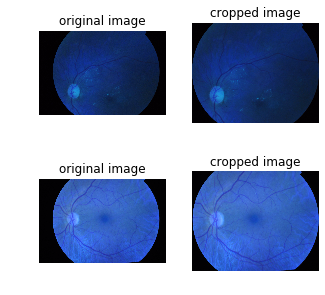

In [8]:
sample_to_show = ['07419eddd6be.png','0124dffecf29.png']

def get_cropped_image_demo(image):
    img = cv2.blur(image,(2,2))
    slice1Copy = np.uint8(img)
    canny = cv2.Canny(slice1Copy, 0, 50)
    pts = np.argwhere(canny>0)
    y1,x1 = pts.min(axis=0)
    y2,x2 = pts.max(axis=0)
    cropped_img = img[y1:y2, x1:x2]
    return np.array(cropped_img)

names = []
samples = []
cropped_images = []
for i in sample_to_show:
    path = train_dir + str(i)
    img_ = cv2.imread(path)
    samples.append(img_)
    cropped_ = get_cropped_image_demo(img_)
    cropped_images.append(cropped_)
    
fig = plt.figure(figsize = (5,5))
ax1 = fig.add_subplot(2,2,1)
ax1.title.set_text('original image'), ax1.axis("off"), plt.imshow(samples[0])
ax2 = fig.add_subplot(2,2,2)
ax2.title.set_text('cropped image'), ax2.axis("off"), plt.imshow(cropped_images[0])
ax3 = fig.add_subplot(2,2,3)
ax3.title.set_text('original image'), ax3.axis("off"), plt.imshow(samples[1])
ax4 = fig.add_subplot(2,2,4)
ax4.title.set_text('cropped image'), ax4.axis("off"), plt.imshow(cropped_images[1]);

#### ImageDataGenerator (Training data)

* In the image data generator function we will use the above defined preprocessing function, as we are resizing and scaling in the above function itself, we will not be defining target_size or the rescale parameters in the generator function. 
* the augmentation we are using is the horizontal flipping and random rotation of the image.

In [9]:
train_aug = ImageDataGenerator(#rescale=1./255,
                               horizontal_flip = True,
                               rotation_range = 30,
                               preprocessing_function = get_cropped_image)

In [10]:
train_generator = train_aug.flow_from_dataframe(dataframe = df_train,
                                               directory = train_dir,
                                               x_col = "id_code",
                                               y_col = "diagnosis",
                                               batch_size = 36, 
                                               class_mode = "categorical")

Found 3295 validated image filenames belonging to 5 classes.


#### ImageDataGenerator (Validation Data)

In [11]:
val_aug = ImageDataGenerator(rescale=1./255)

In [12]:
validation_generator = val_aug.flow_from_dataframe(dataframe = df_val,
                                                    directory = train_dir,
                                                    x_col = "id_code",
                                                    y_col = "diagnosis",
                                                    target_size = size,
                                                    batch_size = 36,
                                                    class_mode = "categorical")

Found 367 validated image filenames belonging to 5 classes.


MODEL:

In [13]:
input_layer = Input(shape = (256,256,3))
base_model = ResNet50(include_top = False, input_tensor = input_layer, weights = "../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5")
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(512, activation = "relu")(x)
x = Dropout(0.3)(x)
x = Dense(512, activation = "relu")(x)
#x = Dropout(0.5)(x)
out = Dense(5, activation = 'softmax')(x)

model = Model(inputs = input_layer, outputs = out)
#model.summary()

/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


This kernel helped me choose the model parameters, and callbacks - [APTOS Blindness Detection - EDA and Keras ResNet50](https://www.kaggle.com/dimitreoliveira/aptos-blindness-detection-eda-and-keras-resnet50?scriptVersionId=16639594)

In [14]:
#optimizer= keras.optimizers.Adagrad(lr=3e-3, decay=3e-3 / 10)


In [15]:
optimizer= keras.optimizers.Adam(lr=0.3e-4)

In [16]:
#optimizer = keras.optimizers.RMSprop(lr=3e-1)

es = EarlyStopping(monitor='val_loss', mode='min', patience = 8, restore_best_weights=True)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience = 3, factor = 0.5, min_lr=1e-6)
    
callback_list = [es, rlrop]

model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"]) 

In [17]:
model.fit_generator(generator = train_generator, steps_per_epoch = len(train_generator), epochs = 30, validation_data = validation_generator, validation_steps = len(validation_generator), callbacks = callback_list)

Epoch 1/30
92/92 [==============================] - 426s 5s/step - loss: 0.9488 - acc: 0.6432 - val_loss: 0.8451 - val_acc: 0.6839
Epoch 2/30
92/92 [==============================] - 401s 4s/step - loss: 0.6680 - acc: 0.7574 - val_loss: 0.7249 - val_acc: 0.7112
Epoch 3/30
92/92 [==============================] - 403s 4s/step - loss: 0.5711 - acc: 0.7852 - val_loss: 0.7936 - val_acc: 0.6730
Epoch 4/30
92/92 [==============================] - 404s 4s/step - loss: 0.4955 - acc: 0.8175 - val_loss: 0.7907 - val_acc: 0.6812
Epoch 5/30
92/92 [==============================] - 403s 4s/step - loss: 0.4612 - acc: 0.8217 - val_loss: 0.8678 - val_acc: 0.6812
Epoch 6/30
92/92 [==============================] - 402s 4s/step - loss: 0.4072 - acc: 0.8404 - val_loss: 0.8405 - val_acc: 0.6975
Epoch 7/30
92/92 [==============================] - 401s 4s/step - loss: 0.3837 - acc: 0.8503 - val_loss: 0.9079 - val_acc: 0.6785
Epoch 8/30
92/92 [==============================] - 400s 4s/step - loss: 0.3339 - a

TEST:

Processing test dataframe.

In [18]:
test_df = pd.read_csv(test_csv)

def process_test_df(test_df):
    test_ids = test_df["id_code"].values.tolist()
    for i in range(len(test_ids)):
        imgname = test_ids[i]
        newname = str(imgname) + ".png"
        test_ids[i] = newname
    test_df["id_code"] = test_ids
    return test_df

test_df = process_test_df(test_df)

Test Data Generator :

In [19]:
test_aug = ImageDataGenerator(rescale = 1./255)

test_generator = test_aug.flow_from_dataframe(dataframe = test_df, 
                                              directory = test_dir,
                                              x_col = "id_code",
                                              batch_size = 1,
                                              target_size = (256,256),
                                              shuffle = False,
                                              class_mode = None)

Found 1928 validated image filenames.


#### PREDICTION

In [20]:
predprobs = model.predict_generator(test_generator, steps=len(test_generator))

In [21]:
predictions = []
for i in predprobs:
    predictions.append(np.argmax(i)) 

In [22]:
id_code = test_df["id_code"].values.tolist()

In [23]:
for i in range(len(id_code)):
    imgid = id_code[i]
    newimgid = imgid[:-4]
    id_code[i] = newimgid

Submission :

In [24]:
subfile = pd.DataFrame({"id_code":id_code, "diagnosis":predictions})

In [25]:
subfile.to_csv('submission.csv',index=False)